# TP4 : Sound Effects and Artificial Reverberation 
by BOUJNOUNI Fatine 

In [1]:
# Imports 
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os, sys, wave, struct
from IPython import display as idp

In [2]:
sound_files = ['Sons/guitare.wav', 'Sons/hand_clap_22mono.wav' , 'Sons/paganini.wav' ]

## 1.  Phasing

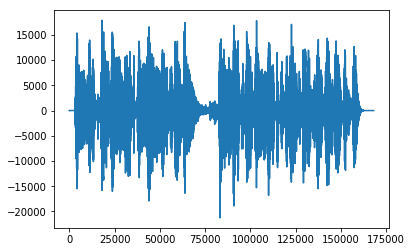

In [3]:
# Guitar sound 
rate, frames = wavfile.read(sound_files[0])

plt.plot(frames)
idp.Audio(frames, rate=rate)

$y(n) = x(n) + a(n)\, x(n-p)$

In [4]:
def Phasing(s, amax, amin, fa, p):
    A = (amax - amin)/2
    B = (amax + amin)/2
    a = B + A*np.sin(2*np.pi*fa*np.arange(len(s))/rate)
    print(a)
    return s + a*np.concatenate((np.zeros(p), s[:-p]))

[1.75       1.75142475 1.75284946 ... 1.83684248 1.83550504 1.83416482]


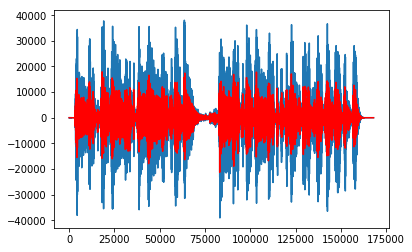

In [5]:
s1 = Phasing(frames,2,1.5,20,100)
plt.plot(s1)
plt.plot(frames, color='r')
idp.Audio(s1, rate=rate)

> A low value of $f_a$ gives higher values of $a$ and the effect is stronger.
Also, when the difference between $amax$ and $amin$ is greater than one, the effect is stronger.

## 2. Flanger 

> 1. The filter reccurent equation : 
$y(n) = x(n) + a\, x\big(n-p(n)\big)$

In [6]:
def Flanger(s, pmax, pmin, fp, a):
    A = (pmax - pmin)/2
    B = (pmax + pmin)/2
    p = B + A*np.sin(2*np.pi*fp*np.arange(len(s))/rate)
    return s + a*s[np.arange(len(s)) - p.astype(np.int)]


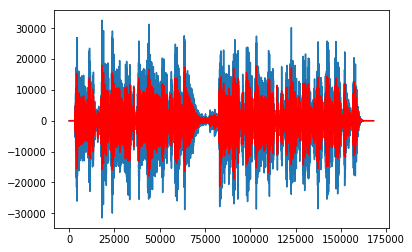

In [7]:
s2 = Flanger(frames,20,10,200,1)
plt.plot(s2)
plt.plot(frames, color='r')
idp.Audio(s2, rate=rate)

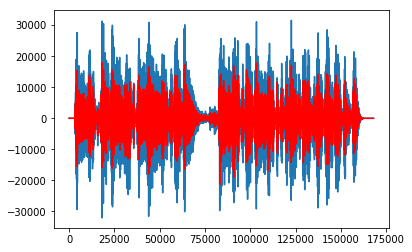

In [8]:
# 3 
s3 = Flanger(frames,10,7,200,1)
plt.plot(s3)
plt.plot(frames, color='r')
idp.Audio(s3, rate=rate)

> When the difference between $pmax$ and $pmin$ is greater , the effect is stronger. 

## 3. Artificial Reverberation 
### 3.1. Early echoes simulation

> 1. The texture of the wall influences how sounds are reverberated. We should understand how much the wall of a certain texture absorbs a frequency to improve the realism of the model for a real room. 

> 2. The room contains 6 walls. We have a source in the point (0,0,0); so for the first order echoes we would have 3 image sources from the walls to whom the source doesn't belong. And for the second order echoes we would have 15 image sources (3*5).

> 3. I think it's not necessary to include higher order echoes. They will be very attenuated. 

In [9]:
def distance(d1, d2):
    d = np.array(d2) - np.array(d1)
    return np.sqrt(np.sum(d**2))

def attenuation(r):
    if r >= 1:
        return 1 / r 
    else:
        1
        
def echoSources(source_pos, mic_pos, room_dim, shift_s):
    """This function computes the echo-sources from a source"""
    echo_sources = []

    for k, M in enumerate(room_dim):
        for i in [0, M]:
            n_source_pos = list(source_pos)
            n_source_pos[k] = i - (source_pos[k] - i)

            n_source_proj_pos = list(n_source_pos)
            n_source_proj_pos[k] = i
            
            dim = [0,1,2]
            dim.remove(k)
            for d in dim:
                if (2 * i - mic_pos[k]) != 0:
                    n_source_proj_pos[d] = mic_pos[d] *i / (2 * i - mic_pos[k])
                else :
                    n_source_proj_pos[d] = 0
            echo_sources.append(n_source_proj_pos)

    echo_sources = [ s for s in echo_sources if (not s == source_pos and not s == mic_pos)]
    echo_sources = list(map( lambda s: {'shift_s': shift_s + distance(source_pos, s),'dist_to_mic': distance(s, mic_pos),'position': s,}, echo_sources))
    return echo_sources

In [10]:
def early_echoes(source_pos, mic_pos, room_dim, s, rate):
    res = np.array(s).astype(np.float)
    
    # Each source is characterized by its shift from the original source,
    # its distance to the microphone and its position
    dist_to_mic = distance(source_pos, mic_pos)
    current_sources = {'shift_s': 0,'dist_to_mic': dist_to_mic,'position': source_pos }
    Sources = [current_sources]    
    echo_sources = []
    
    # We compute the second order echoes
    for _ in range(2):
        # Compute echo sources for each source
        
        for src in Sources:
            pos =src['position'] 
            p = src['shift_s']
            current_echo_sources = echoSources(pos, mic_pos, room_dim, p)
            echo_sources = np.concatenate((echo_sources, current_echo_sources))

        for src in echo_sources:
            dist1 = dist_to_mic
            dist2 = src['shift_s'] + src['dist_to_mic']
            shift = int((abs(dist2 - dist1)/300) * rate)
            res += attenuation(dist2) * np.concatenate((s[shift:], np.zeros(shift)))

        current_sources = list(echo_sources)
    return res

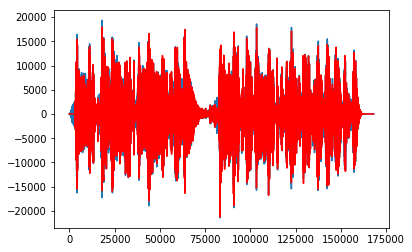

In [11]:
source_pos1 = [0, 0, 0]
mic_pos1 = [1, 0, 0]
room_dim1 = [20, 15, 10]
s4 = early_echoes(source_pos1, mic_pos1, room_dim1, frames, rate)

plt.plot(s4)
plt.plot(frames, color='r')

idp.Audio(s4, rate=rate)

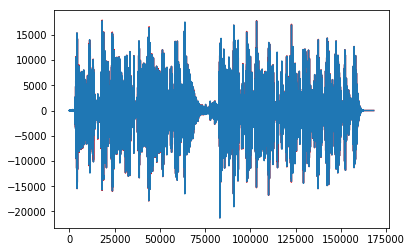

In [12]:
source_pos2 = [0, 0, 0]
mic_pos2 = [1, 0, 0]
room_dim2 = [200, 150, 100]
s5 = early_echoes(source_pos2, mic_pos2, room_dim2, frames, rate)

plt.plot(frames, color='r')
plt.plot(s5)

idp.Audio(s5, rate=rate)

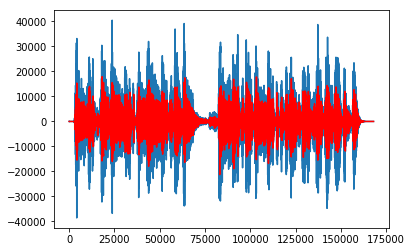

In [13]:
source_pos3 = [0, 0, 0]
mic_pos3 = [1, 0, 0]
room_dim3 = [2, 2, 2]
s6 = early_echoes(source_pos3, mic_pos3, room_dim3, frames, rate)


plt.plot(s6)
plt.plot(frames, color='r')
idp.Audio(s6, rate=rate)

> The effect of early echoes is stronger when the room is very small

### 3.2. Late reverberation : Schoroeder reverberator

> 1. We have $$\frac{20 log_{10}(g_i)}{m_iT} = \frac{-60}{Tr}$$
$$log_{10}(g_i) = \frac{-3*m_iT}{Tr} $$
Thus : $$g_i = 10^{\frac{-3 m_i T}{T_r}}$$

> 2.

In [14]:
def gain(T, Tr, m, filter_type):
    if filter_type=='comb':
        return 10 ** (-3 * m * T / Tr)
    else:  # Filter type = allpass
        return (1 - 7 * T / Tr) ** m
    
def comb_filters(s, ampl, d, rate):
    shift = int(d * rate)
    return s + ampl * np.concatenate((np.zeros(shift), s[:-shift]))

def allpass_filters(s, ampl, d, rate):
    shift = int(d * rate)
    return s + ampl * np.concatenate((np.zeros(shift), s[:-shift])) - ampl * np.concatenate((s[shift:], np.zeros(shift)))

def Schroeder(s, rate, comb_filters_delays, allPass_filters_delays):
    signal = np.array(s).astype(np.float)
    T = 1 / rate # (1 / FrameRate)
    Tr = 2

    for d in comb_filters_delays:
        signal += comb_filters(signal, gain(T, Tr, d, filter_type='comb'), d, rate )

    for d in allPass_filters_delays:
        signal += allpass_filters(signal, gain(T, Tr, d, filter_type='allpass'), d, rate)

    return signal

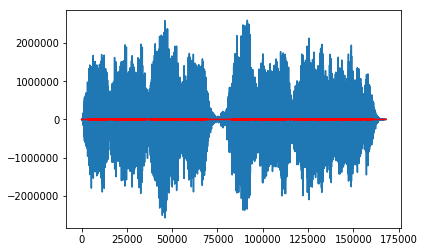

In [15]:

comb_filters_delays = np.array([0.0297, 0.0371, 0.0414, 0.0437])
allPass_filters_delays = np.array([0.09683, 0.03292])

s7 = Schroeder(frames, rate, comb_filters_delays, allPass_filters_delays)
plt.plot(s7)
plt.plot(frames, color='r')
idp.Audio(s7, rate=rate)

In [133]:
def echoes_Schroeder(source_pos, mic_pos, room_dim, s, rate, comb_filters_delays, allPass_filters_delays):
    res = np.array(s).astype(np.float)
    
    # Each source is characterized by its shift from the original source,
    # its distance to the microphone and its position
    dist_to_mic = distance(source_pos, mic_pos)
    current_sources = {'shift_s': 0,'dist_to_mic': dist_to_mic,'position': source_pos }
    Sources = [current_sources]    
    echo_sources = []
    
    # We compute the second order echoes
    for _ in range(2):
        # Compute echo sources for each source
        
        for src in Sources:
            pos =src['position'] 
            p = src['shift_s']
            current_echo_sources = echoSources(pos, mic_pos, room_dim, p)
            echo_sources = np.concatenate((echo_sources, current_echo_sources))

        for src in echo_sources:
            dist1 = dist_to_mic
            dist2 = src['shift_s'] + src['dist_to_mic']
            shift = int((abs(dist2 - dist1)/300) * rate)
            signal = attenuation(dist2) * np.concatenate((s[shift:], np.zeros(shift)))
            res += Schroeder(signal, rate, comb_filters_delays, allPass_filters_delays)

    return res

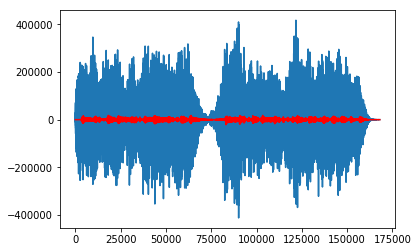

In [142]:
s8 = echoes_Schroeder(source_pos1, mic_pos1, room_dim1, frames, rate, comb_filters_delays, allPass_filters_delays)

plt.plot(s8)
plt.plot(frames, color='r')

idp.Audio(s8, rate=rate)

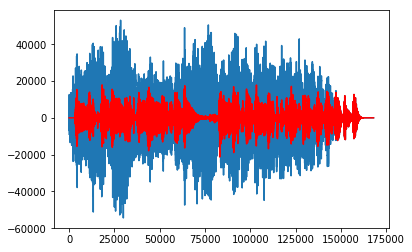

In [143]:
s9 = echoes_Schroeder(source_pos2, mic_pos2, room_dim2, frames, rate, comb_filters_delays, allPass_filters_delays)

plt.plot(s9)
plt.plot(frames, color='r')

idp.Audio(s9, rate=rate)

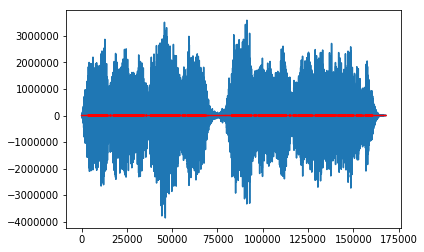

In [144]:
s10 = echoes_Schroeder(source_pos3, mic_pos3, room_dim3, frames, rate, comb_filters_delays, allPass_filters_delays)

plt.plot(s10)
plt.plot(frames, color='r')

idp.Audio(s10, rate=rate)

> when the room dimension are very small, we hear more the effect of reverberation. But when the room is very big, we hear more the effect of early echoes.